**Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
import warnings
warnings.filterwarnings("ignore")
import joblib
import os
for dirname, _, filenames in os.walk('/deceptive-opinion.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:\Users\user\AppData\Local\Temp\ipykernel_19140\220067361.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Data Check and Exploration**

In [3]:
df = pd.read_csv('deceptive-opinion.csv')

In [4]:
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [5]:
df = df.sample(frac=1)

In [6]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df['deceptive']= label_encoder.fit_transform(df['deceptive'])

df['deceptive'].unique()

array([1, 0])

In [7]:
df.groupby('deceptive').describe()

hotel                      polarity                       source  \
          count unique      top freq    count unique       top freq  count   
deceptive                                                                    
0           800     20  affinia   40      800      2  negative  400    800   
1           800     20   conrad   40      800      2  positive  400    800   

                                    text         \
          unique          top freq count unique   
deceptive                                         
0              1        MTurk  800   800    800   
1              2  TripAdvisor  400   800    796   

                                                                   
                                                         top freq  
deceptive                                                          
0          If you are looking for a high end hotel on the...    1  
1          I'd been searching for a cool, non-chain hotel...    2

**Data Cleaning and standarization**

In [8]:
def clean_text(text):

    text = text.translate(string.punctuation)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)

    # Data Cleaning
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [9]:
# Punctuation Cleaning
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_char(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

In [10]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [11]:
df['text'] = df['text'].map(lambda a: clean_numbers(a))

In [12]:
df['text'] = df['text'].map(lambda a: clean_char(a))

In [13]:
df['text'] = df['text'].map(lambda a: clean_text(a))

In [14]:
df['text']

11      first trip chicago litll worri hotel locat fin...
1401    look high end hotel magnific mile affinia chic...
1126    husband month old took quick trip chicago stay...
894     general speak noth bad place would clean issu ...
1236    stay hyatt regenc experi never ever forget goo...
                              ...                        
1159    stay palmer hous attend confer chicago state b...
657     stay weekend visit friend town littl pricey de...
1251    stay fairmont chicago millennium park hotel fa...
534     stay hilton like live luxuri day never want ba...
961     stay night spring break call suit resembl wide...
Name: text, Length: 1600, dtype: object

In [15]:
df.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 11 to 961
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   int32 
 1   hotel      1600 non-null   object
 2   polarity   1600 non-null   object
 3   source     1600 non-null   object
 4   text       1600 non-null   object
dtypes: int32(1), object(4)
memory usage: 68.8+ KB


**Training and Testing Data Split**

In [17]:
x = df['text']
y = df['deceptive']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['deceptive'], random_state=5)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 1600
Number of rows in the training set: 1200
Number of rows in the test set: 400


In [20]:
X_train, X_test, y_train, y_test

(176     return two night stay affinia chicago visit de...
 385     stay night may say hotel except clean modern f...
 952     stay sheraton royal orchid hotel bangkok expec...
 135     boyfriend amaz breathtak view lake michigan te...
 175     excel locat block michigan ave two block water...
                               ...                        
 852     nice big room stinki mildew hallway fair room ...
 831     son join husband work trip plan swim work over...
 91      love hotel fabul old build first class modern ...
 1168    check room empti beer bottl dirti underwear cl...
 544     compani host seminar millennium knickerbock ho...
 Name: text, Length: 1200, dtype: object,
 919     book thru hotwir high percentag posit outcom h...
 8       arriv omni 2nd septemb day stay took ill left ...
 1304    realli high hope homewood suit stay week long ...
 772     fiance look modern upscal venu wed recept foun...
 963     stay affinia one night purpos drive way suburb...
              

**Text Vectorization**

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()
print(count_vector)

CountVectorizer()


In [22]:
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

**Data Transform**

In [23]:
# Sparse matrices convertion into dense NumPy arrays
X_train_dense = training_data.toarray()
X_test_dense = testing_data.toarray()


<h1>Neural Network Creation and Development<h1>

In [24]:
model = Sequential()

# LAYER CREATION FOR OUR NEURAL NETWORK:

# 1. Input layer (uses the size of vocabulary and input vectors size)
model.add(Embedding(input_dim=len(count_vector.get_feature_names_out()), output_dim=64, input_length=training_data.shape[1]))

# 2. Embedding output Flattening
model.add(Flatten())

# 3. Hidden layer(s)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# 4. Output layer (Binary Classification)
model.add(Dense(1, activation='sigmoid'))

In [25]:
# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [26]:
# Model Training: 15 Epochs to optimize the cost-benefit trade-off between performance and processing of our neural network
model.fit(X_train_dense, y_train, epochs=15, batch_size=64, validation_split=0.2)


Epoch 1/15


15/15 [==============================] - 7s 397ms/step - loss: 1.9965 - accuracy: 0.5052 - val_loss: 0.7088 - val_accuracy: 0.5417
Epoch 2/15
15/15 [==============================] - 5s 366ms/step - loss: 0.7084 - accuracy: 0.5458 - val_loss: 0.6592 - val_accuracy: 0.5667
Epoch 3/15
15/15 [==============================] - 6s 369ms/step - loss: 0.6417 - accuracy: 0.6250 - val_loss: 0.6417 - val_accuracy: 0.6125
Epoch 4/15
15/15 [==============================] - 5s 358ms/step - loss: 0.5989 - accuracy: 0.6427 - val_loss: 0.7040 - val_accuracy: 0.4917
Epoch 5/15
15/15 [==============================] - 5s 356ms/step - loss: 0.4861 - accuracy: 0.7844 - val_loss: 0.5521 - val_accuracy: 0.6792
Epoch 6/15
15/15 [==============================] - 5s 358ms/step - loss: 0.3429 - accuracy: 0.8844 - val_loss: 0.4212 - val_accuracy: 0.8125
Epoch 7/15
15/15 [==============================] - 5s 357ms/step - loss: 0.2419 - accuracy: 0.9250 - val_loss: 0.3733 - val_accuracy: 0.8458
Epoc

**Model Evaluation**

In [27]:
# Testing set Accuracy
test_loss, test_accuracy = model.evaluate(X_test_dense, y_test)
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 0s 20ms/step - loss: 0.4592 - accuracy: 0.8450
Test Accuracy: 0.8450000286102295


13/13 [==============================] - 0s 20ms/step


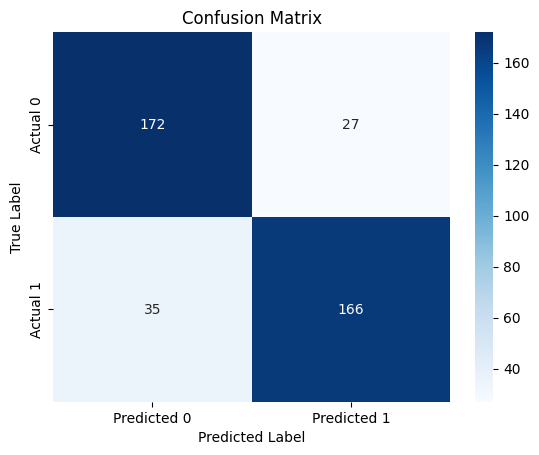

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.predict(X_test_dense)
predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion matrix creation
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Plot for the Confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test_dense)
predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification Report
print("Classification Report:\n", classification_report(y_test, predictions_binary))

13/13 [==============================] - 0s 18ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       199
           1       0.86      0.83      0.84       201

    accuracy                           0.84       400
   macro avg       0.85      0.85      0.84       400
weighted avg       0.85      0.84      0.84       400



In [30]:
# Saving the Model into a file
model.save("lie_detection_model.h5")
joblib.dump(count_vector, 'count_vectorizer_nn.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']